# Bayesian Linear Regression

Here we consider linear regression from a Bayesian perspective. We'll begin by generating a noisy dataset, projecting our input data into some feature space, and finally computing the predictive distribution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from core import generate_dataset, plot_with_error_regions

## Generating some data

Let's make a function that generates a synthetic dataset. The function will take a function as input that determines how to generate a noise-free dataset, and then adds gaussian noise with zero mean and a variance given as an argument.

For now, we'll work with a noisy sine wave.

In [2]:
DATASET_SIZE=500
X_RANGE = [-4*np.pi, 4*np.pi]

dataset = generate_dataset(DATASET_SIZE, X_RANGE, lambda x: np.sin(0.5*x))
dataset_x = dataset[0]
dataset_y = dataset[1]

In [3]:
plt.scatter(dataset_x, dataset_y)
plt.show()

## Projecting the data in polynomial space

Now, we're going project our input space into polynomial space -- meaning we're going to perform the map $x\mapsto (1, x, x^2, x^3,\dots,x^{P-1})^T$ for some feature space dimension $P$. We'll call this map $\mathbf\phi(x)$, and we'll refer to the matrix of all transformed inputs $\mathbf\phi$.

In [4]:
P = 8

def project_to_polynomial_space(x, P):
    return np.array([x ** p for p in range(P)])

phi = np.array([project_to_polynomial_space(x, P) for x in dataset_x])

assert phi.shape == (DATASET_SIZE, P)

## Deriving the Linear Regression

We're modelling each target datapoint $y_i$ as a linear map from the feature vector $\phi(x_i)$ with an additive zero-centered Gaussian noise. The variance of this noise, $\sigma_n^2$, will be a hyperparameter. So, we have

$$
y_i = \mathbf\phi(x_i) + \mathcal{N}(0, \sigma_n^2)\\
\therefore p(\mathbf{y}|\mathbf\phi,\mathbf{w}) = \mathcal{N}(\mathbf{y}|\mathbf\phi\mathbf{w}, \sigma_n^2I)
$$

where $\mathbf{y}\in\mathbb{R}^{n}$ is the vector of target datapoints, $\mathbf{w}\in\mathbb{R}^P$ is a vector of weights, and $n$ is the amount of datapoints in the dataset.

In order to practice a Bayesian treatment, we must place a prior distribution of the parameters of the model, $\mathbf{w}$. We'll model this prior as a zero-centered multivariate Gaussian, and, to keep things simple, we'll make it an isotropic Gaussian with variance $\sigma_p^2I$. So, we have

$$p(\mathbf{w}) = \mathcal{N}(\mathbf{w}|\mathbf{0},\sigma_p^2I)$$

### Posterior distribution on the weights

Now we can find the posterior distribution on the weights, $p(\mathbf{w}|\mathbf\phi,\mathbf{y})$. Using Bayes rule, we have $p(\mathbf{w}|\mathbf\phi,\mathbf{y})\propto p(\mathbf{y}|\mathbf{w}\mathbf\phi)p(\mathbf{w}) = \mathcal{N}(\mathbf{y}|\mathbf\phi\mathbf{w}, \sigma_n^2I)\mathcal{N}(\mathbf{w}|\mathbf{0},\sigma_p^2I)$. We now complete the square (with respect to $\mathbf{w}$) to derive the posterior distribution, which will also be Gaussian.

$$
p(\mathbf{w}|\mathbf\phi,\mathbf{y})\propto \exp\left[-\frac{1}{2}\left(\frac{1}{\sigma_n^2}(\mathbf{y}^T - \mathbf{w}^T\mathbf\phi^T)(\mathbf{y}-\mathbf\phi\mathbf{w}) + \frac{1}{\sigma_p^2}(\mathbf{w}^T\mathbf{w})\right)\right]
$$

We want to manipulate the exponent to get a quadratic in $\mathbf{w}$. This will be of the form:

$$(\mathbf{w}^T-\mathbf\mu^T)\Lambda(\mathbf{w}-\mathbf\mu) = \mathbf{w}^T\Lambda\mathbf{w} - 2\mathbf{w}^T\Lambda\mathbf\mu + C$$

where $C$ is a constant independent of $\mathbf\mu$. We'll now regroup the variables in the posterior from above:

$$
p(\mathbf{w}|\mathbf\phi,\mathbf{y})\propto \exp\left(-\frac{1}{2}\left[\mathbf{w}^T\left(\frac{1}{\sigma_n^2}\mathbf\phi^T\mathbf\phi + \frac{1}{\sigma_p^2}I\right)\mathbf{w} -2\mathbf{w}^T\left(\frac{1}{\sigma_n^2}\mathbf\phi^T\right)\mathbf{y} + C\right]\right)
$$

Matching with the form of the complete square shown above, we first note that $\Lambda = \frac{1}{\sigma_n^2}\mathbf\phi^T\mathbf\phi + \frac{1}{\sigma_p^2}I$.

Now, we must have $\Lambda\mathbf\mu = \sigma_n^{-2}\mathbf\phi^T\mathbf{y}$. Therefore, $\mathbf\mu = \sigma_n^{-2}\Lambda^{-1}\phi^T\mathbf{y}$. If we were simply using a maximum *a posteriori* estimate of $\mathbf{w}$, since the mode of a Gaussian is the same as the mean, we'd get:

$$
\mathbf{w} = \sigma_n^{-2}\left(\frac{1}{\sigma_n^2}\mathbf\phi^T\mathbf\phi + \frac{1}{\sigma_p^2}I\right)^{-1}\mathbf{\phi}^T\mathbf{y}
$$

Note that this is equivalent to the estimation of parameters by ridge regression! However, through our model, we see that ridge regression is equivalent to placing a Gaussian prior on the weights, and the regularization hyperparameter controls the variance on this prior.

### The predictive distribution

In the Bayesian setting, the goal is not to estimate the weights, but rather to have a distribution over predictions due to our uncertainty in the weights. Consider the problem of predicting some new target $y_*$ according to a new input $x_*$. We have:

$$
p(y_*|\mathbf\phi(x_*), \mathbf\phi, \mathbf{y}) = \int_{\mathbf{w}}p(y_*|\mathbf\phi(x_*),\mathbf{w})p(\mathbf{w}|\mathbf\phi,\mathbf{y})d\mathbf{w}
$$
$$
p(y_*|\mathbf\phi(x_*), \mathbf\phi, \mathbf{y}) = \int_{\mathbf{w}}\mathcal{N}(y_*|\mathbf\phi(x_*)\mathbf{w}, \sigma_n^2)\mathcal{N}(\mathbf{w}|\mathbf\mu, \Lambda^{-1})d\mathbf{w}
$$

This is equivalent to marginalizing a Gaussian distribution. Bishop shows in [PRML](https://www.microsoft.com/en-us/research/people/cmbishop/#!prml-book) that with the following distributions,

$$
p(\mathbf{w}) = \mathcal{N}(\mathbf{w}|\mathbf\mu, \Lambda^{-1})\\
p(y | \mathbf{w}) = \mathcal{N}(y|\mathbf{x}^T\mathbf{w} + b, \sigma_n^{2})
$$

marginalizing over the variable $\mathbf{w}$ gives

$$
p(y) = \mathcal{N}(y | \mathbf{x}^T\mathbf\mu + b, \sigma_n^2 + \mathbf{x}^T\Lambda^{-1}\mathbf{x})
$$

Matching with the form of our predictive distribution, we have $y = y_*, \mathbf{x} = \mathbf\phi(x_*), b = 0$. So, the posterior distribution can be written as:

$$
p(y_*|\mathbf\phi(x_*), \mathbf\phi,\mathbf{y}) = \mathcal{N}(\mathbf\phi(x_*)^T\mathbf\mu, \sigma_n^2 + \mathbf\phi(x_*)^T\Lambda^{-1}\mathbf\phi(x_*))
$$

## Implementing the Bayesian Linear Regression

In [5]:
class BayesianLinearRegressor:
    def __init__(self, sn, sp):
        self._sn = sn
        self._sp = sp
        
    def fit(self, phi, y):
        self._lambda_inv = np.linalg.inv((1/self._sn) * phi.T.dot(phi) + (1/self._sp) * np.eye(phi.shape[1]))
        self._mu = (1/self._sn) * self._lambda_inv.dot(phi.T.dot(y))
    
    def predict(self, x):
        sample_mean, sample_var = self.prediction_params(x)
        return np.random.normal(sample_mean, sample_var)
    
    def prediction_params(self, x):
        return x.T.dot(self._mu), self._sn + x.T.dot(self._lambda_inv.dot(x))

## Observing results

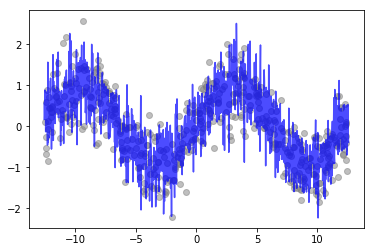

In [6]:
regressor = BayesianLinearRegressor(0.5, 2)
regressor.fit(phi, dataset_y)

xs = np.linspace(X_RANGE[0], X_RANGE[1], 1000)
phis = np.array([project_to_polynomial_space(x, P) for x in xs])
ys_sampled = [regressor.predict(x) for x in phis]
plt.scatter(dataset_x, dataset_y, color='grey', alpha=0.5)
plt.plot(xs, ys_sampled, color='blue', alpha=0.7)
plt.show()

So it looks like our model learned a pretty good fit. However, due to the noise involved in sampling from the posterior distribution, it's difficult to see if it's overfitting, and what the uncertainty looks like over the domain. Let's instead observe the mean prediction with some error bars.

In [7]:
plt.scatter(dataset_x, dataset_y, color='grey', alpha=0.5)
plot_with_error_regions(xs, regressor, projector=lambda x: project_to_polynomial_space(x, P))

Now let's see what happens when we try to sample from the predictive distribution outside the range of the input in the dataset.

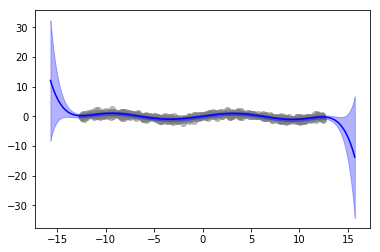

In [8]:
EXTRA_WIDTH=np.pi
wider_xs = np.linspace(X_RANGE[0]-EXTRA_WIDTH, X_RANGE[1] + EXTRA_WIDTH, 1000)
plt.scatter(dataset_x, dataset_y, color='grey', alpha=0.5)
plot_with_error_regions(wider_xs, regressor, projector=lambda x: project_to_polynomial_space(x, P))

Awesome! This shows that the regressor demonstrates increasingly more uncertainty as the input veers further away from the domain of the inputs of the dataset.